#  AIPI 590 Applied Machine Learning

### Alejandro Paredes La Torre

In [1]:
import numpy as np
import pandas as pd
import glob
import math
import os
import torch
import random
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [3]:
# Get the total number of images in each class
file_count = 0
classes = os.listdir("C:/Users/ALEJANDRO/Documents/7. DUKE/1. AIPI 590 - Computer Vision/assignment/First_group_project/CV_Places365/data/train_data")
print('Classes:',len(classes))
for cat in ['train_data', 'test_data']: #'val',
  files = glob.glob('C:/Users/ALEJANDRO/Documents/7. DUKE/1. AIPI 590 - Computer Vision/assignment/First_group_project/CV_Places365/data/'+cat+'/*/*')
  print(cat,'Images:',len(files), end = ', ')
print('\n')
for direc in classes:
  files = glob.glob('C:/Users/ALEJANDRO/Documents/7. DUKE/1. AIPI 590 - Computer Vision/assignment/First_group_project/CV_Places365/data/*/'+direc+'/*')
  file_count += len(files)
  print(direc, len(files))
print(file_count)

Classes: 5
train_data Images: 25000, test_data Images: 500, 

airport_terminal 5100
aquarium 5100
bar 5100
beach 5100
music_studio 5100
25500


## **Load The Data**

In [4]:
data_dir = "C:/Users/ALEJANDRO/Documents/7. DUKE/1. AIPI 590 - Computer Vision/assignment/First_group_project/CV_Places365/data"
random.seed(41)

#Data Tranforms (Augmentation and Normalization)
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(30),
                                       transforms.RandomPerspective(distortion_scale=0.4),
                                       transforms.RandomHorizontalFlip(0.6),
                                       transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
val_transforms = transforms.Compose([
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(0.6),
                                       transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

#Getting all the data with PyTorch Datasets
train_data = datasets.ImageFolder(data_dir + '/train_data', transform= train_transforms)
val_data = datasets.ImageFolder(data_dir + '/test_data', transform= val_transforms)
test_data = datasets.ImageFolder(data_dir + '/test_data', transform= test_transforms)

#Loading the data into PyTorch DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size= 128, shuffle = True,num_workers=2)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size= 64, shuffle = True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= 64, shuffle = True,num_workers=2)

#Creating a dictionary of all classes
classes = dict(zip(list(range(len(train_data.classes))),train_data.classes))

### **Check the images with labels**

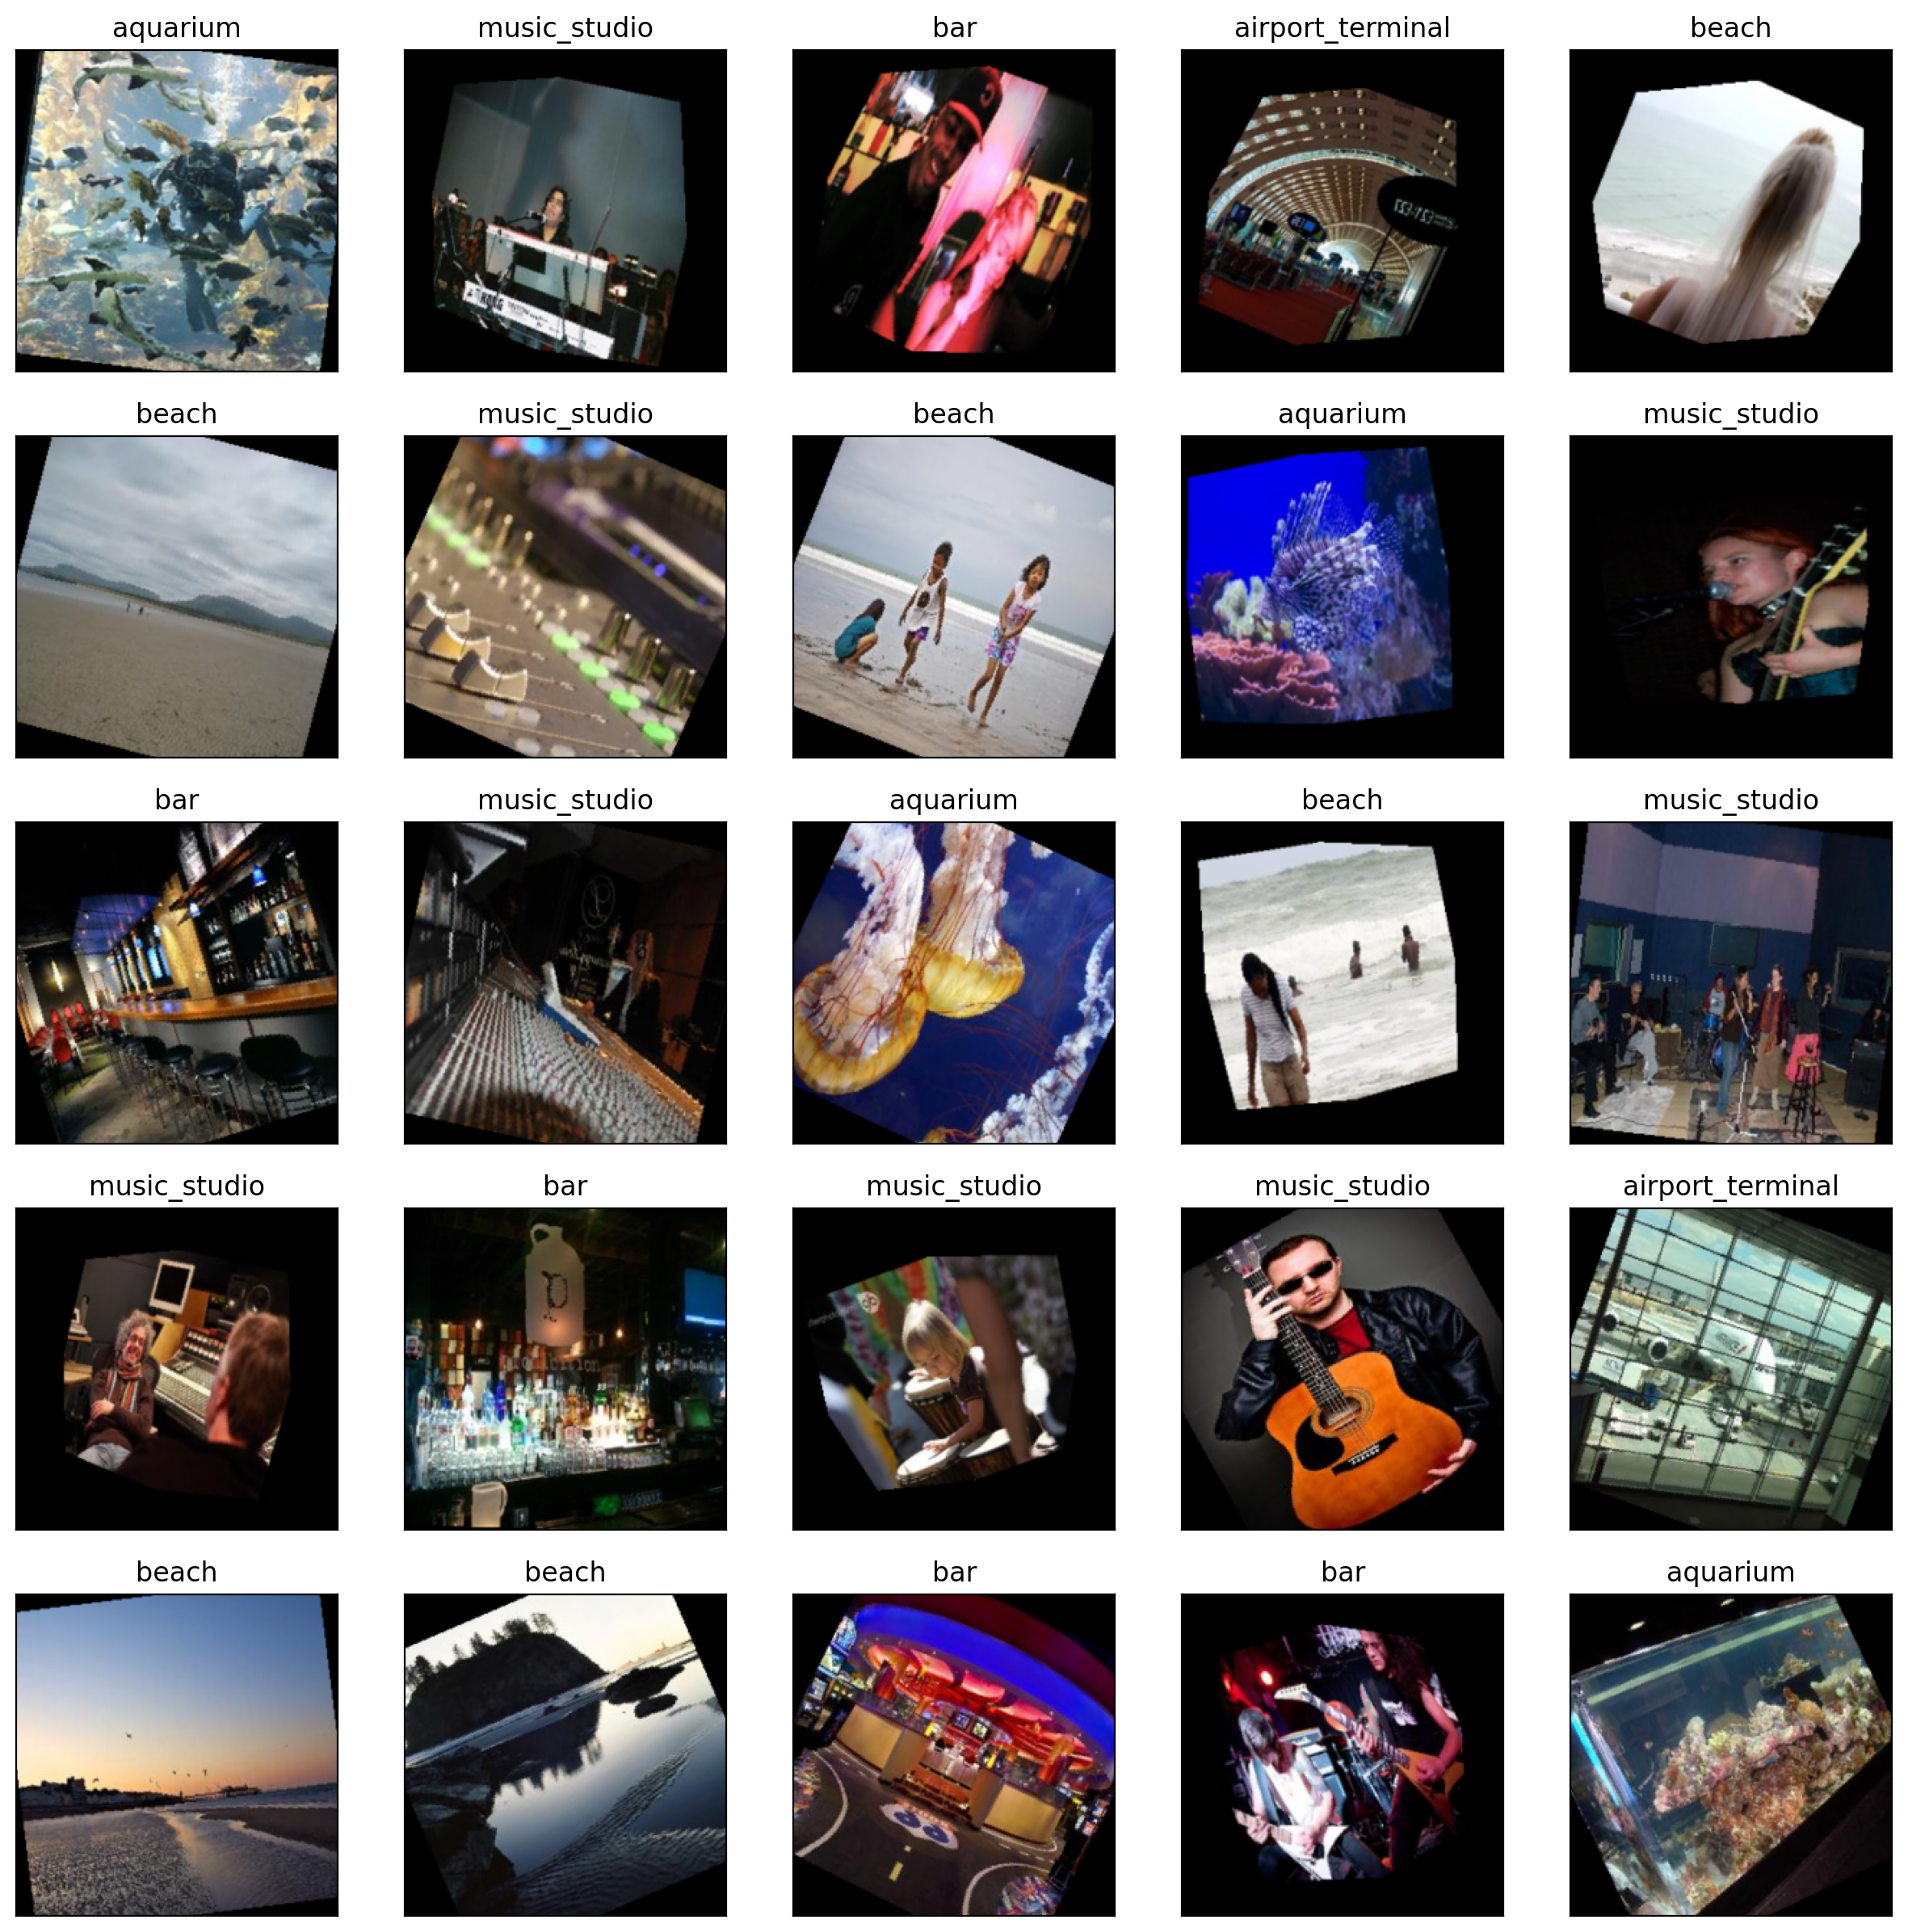

In [5]:
def denormalise(image):
    try:
        image = image.cpu().numpy().transpose(1, 2, 0)
    except:
        image = image.transpose(1, 2, 0)  # PIL images have channel last
    mean = [0.485, 0.456, 0.406]
    stdd = [0.229, 0.224, 0.225]
    image = (image * stdd + mean).clip(0, 1)
    return image

dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use next() instead of dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(15, 15))

for idx in np.arange(25):
    ax = fig.add_subplot(5, 5, idx + 1, xticks=[], yticks=[])
    ax.imshow(denormalise(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx].item()])


## **Load the model**

In [6]:
# Specify the device type
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
# Load VGG16 pretrained model
model = models.vgg16(pretrained=True)

# Freeze the feature extraction layers
for param in model.features.parameters():
    param.requires_grad = False

# Customize the classifier to match your output classes
model.classifier = nn.Sequential(
    nn.Linear(25088, 512),  # 25088 is the flattened size of VGG16's last conv layer output
    nn.Dropout(0.6),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, len(classes))  # Adjust the final layer to the number of classes
)

# Unfreeze the classifier for training
for param in model.classifier.parameters():
    param.requires_grad = True

# Move the entire model to the GPU
model = model.to(device)

c:\Users\ALEJANDRO\Documents\5. Programming\.virtualenvs\aplt_duke\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ALEJANDRO\Documents\5. Programming\.virtualenvs\aplt_duke\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ALEJANDRO\Documents\5. Programming\.virtualenvs\aplt_duke\lib\site-packages\torch\nn\modules\module.py:1160: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocator

### **Specify the Loss Criterion, Optimizer and Scheduler**

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.classifier.parameters(),lr= 1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.35)

## **Train The Model**

In [9]:
epochs = 10 # Number of epochs
steps = 0
print_every = 5 
train_losses, valid_losses,valid_acc = [], [], [] # List keeping track of losses and accuracy to plot later
valid_loss_min = np.inf # It will be used to save model whenever Vallidation loss decreases
valid_acc_min = 0.0 

for e in range(epochs):
  
  train_loss = 0 
  model.train()
  #train the model
  for images, labels in train_loader:
    steps+=1
    # Move tensor to device('cuda' in case of GPU or 'cpu' in case of CPU)
    images, labels = images.to(device), labels.to(device)
    # Clearing all the previous gradients
    optimizer.zero_grad()
    # Forward Pass
    logits = model(images)
    # Loss calculation
    loss = criterion(logits,labels)
    # Backward Pass
    loss.backward()
    # Update the parameters
    optimizer.step()
    # Updating the losses list
    train_loss += loss.item()


    # Evaluating after specific amount of steps
    if steps % print_every == 0:
      valid_loss = 0
      accuracy = 0
      # Setting Model to Evaluation Mode
      model.eval()
      with torch.no_grad():
        # Getting Validation loss
        for images, labels in valid_loader:
          images, labels = images.to(device), labels.to(device)
          logits = model(images)
          batch_loss = criterion(logits,labels)
          valid_loss += batch_loss.item()
          
          # Calculating Accuracy
          output = F.softmax(logits,dim=1)
          top_p,top_class = output.topk(1,dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      # Printing stats    
      print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {train_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}.. "
                  f"LR : {scheduler.get_lr():}"
                  )
      valid_loss = valid_loss/len(valid_loader)
      train_losses.append(train_loss/print_every)
      valid_losses.append(valid_loss)
      valid_acc.append(accuracy/len(valid_loader))
      
      # Checking if Validation loss decreased
      if valid_loss <= valid_loss_min:
        
        # if decreased, it will save the model
        print('valid loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'C:/Users/ALEJANDRO/Documents/7. DUKE/1. AIPI 590 - Computer Vision/assignment/First_group_project/CV_Places365/scenes_vgg16.pt')
        valid_loss_min = valid_loss
      
      
  # Scheduler performing a step to change learning rate of Optimizer    
  scheduler.step()

c:\Users\ALEJANDRO\Documents\5. Programming\.virtualenvs\aplt_duke\lib\site-packages\torch\optim\lr_scheduler.py:525: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 1/10.. Train loss: 1.589.. Validation loss: 1.526.. Validation accuracy: 0.583.. LR : [0.0001]
valid loss decreased (inf --> 1.525582).  Saving model ...
Epoch 1/10.. Train loss: 3.045.. Validation loss: 1.283.. Validation accuracy: 0.740.. LR : [0.0001]
valid loss decreased (1.525582 --> 1.282599).  Saving model ...
Epoch 1/10.. Train loss: 4.232.. Validation loss: 0.970.. Validation accuracy: 0.819.. LR : [0.0001]
valid loss decreased (1.282599 --> 0.970487).  Saving model ...
Epoch 1/10.. Train loss: 5.133.. Validation loss: 0.707.. Validation accuracy: 0.844.. LR : [0.0001]
valid loss decreased (0.970487 --> 0.707389).  Saving model ...
Epoch 1/10.. Train loss: 5.823.. Validation loss: 0.548.. Validation accuracy: 0.852.. LR : [0.0001]
valid loss decreased (0.707389 --> 0.547548).  Saving model ...
Epoch 1/10.. Train loss: 6.374.. Validation loss: 0.468.. Validation accuracy: 0.832.. LR : [0.0001]
valid loss decreased (0.547548 --> 0.467697).  Saving model ...
Epoch 1/10.. Tr

### **Analysis of Training and Validation Losses and Accuracy**

In [9]:
model.load_state_dict(torch.load("C:/Users/ALEJANDRO/Documents/7. DUKE/1. AIPI 590 - Computer Vision/assignment/First_group_project/CV_Places365/scenes_vgg16.pt"))

C:\Users\ALEJANDRO\AppData\Local\Temp\ipykernel_3444\2619244142.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("C:/Users/ALEJANDRO/Docu

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "fc.weight", "fc.bias", "classifier.8.weight", "classifier.8.bias". 
	Unexpected key(s) in state_dict: "conv_stem.weight", "blocks.0.0.conv_dw.weight", "blocks.0.0.bn1.weight", "blocks.0.0.bn1.bias", "blocks.0.0.bn1.running_mean", "blocks.0.0.bn1.running_var", "blocks.0.0.bn1.num_batches_tracked", "blocks.0.0.se.conv_reduce.weight", "blocks.0.0.se.conv_reduce.bias", "blocks.0.0.se.conv_expand.weight", "blocks.0.0.se.conv_expand.bias", "blocks.0.0.conv_pw.weight", "blocks.0.0.bn2.weight", "blocks.0.0.bn2.bias", "blocks.0.0.bn2.running_mean", "blocks.0.0.bn2.running_var", "blocks.0.0.bn2.num_batches_tracked", "blocks.0.1.conv_dw.weight", "blocks.0.1.bn1.weight", "blocks.0.1.bn1.bias", "blocks.0.1.bn1.running_mean", "blocks.0.1.bn1.running_var", "blocks.0.1.bn1.num_batches_tracked", "blocks.0.1.se.conv_reduce.weight", "blocks.0.1.se.conv_reduce.bias", "blocks.0.1.se.conv_expand.weight", "blocks.0.1.se.conv_expand.bias", "blocks.0.1.conv_pw.weight", "blocks.0.1.bn2.weight", "blocks.0.1.bn2.bias", "blocks.0.1.bn2.running_mean", "blocks.0.1.bn2.running_var", "blocks.0.1.bn2.num_batches_tracked", "blocks.1.0.conv_pw.weight", "blocks.1.0.bn1.weight", "blocks.1.0.bn1.bias", "blocks.1.0.bn1.running_mean", "blocks.1.0.bn1.running_var", "blocks.1.0.bn1.num_batches_tracked", "blocks.1.0.conv_dw.weight", "blocks.1.0.bn2.weight", "blocks.1.0.bn2.bias", "blocks.1.0.bn2.running_mean", "blocks.1.0.bn2.running_var", "blocks.1.0.bn2.num_batches_tracked", "blocks.1.0.se.conv_reduce.weight", "blocks.1.0.se.conv_reduce.bias", "blocks.1.0.se.conv_expand.weight", "blocks.1.0.se.conv_expand.bias", "blocks.1.0.conv_pwl.weight", "blocks.1.0.bn3.weight", "blocks.1.0.bn3.bias", "blocks.1.0.bn3.running_mean", "blocks.1.0.bn3.running_var", "blocks.1.0.bn3.num_batches_tracked", "blocks.1.1.conv_pw.weight", "blocks.1.1.bn1.weight", "blocks.1.1.bn1.bias", "blocks.1.1.bn1.running_mean", "blocks.1.1.bn1.running_var", "blocks.1.1.bn1.num_batches_tracked", "blocks.1.1.conv_dw.weight", "blocks.1.1.bn2.weight", "blocks.1.1.bn2.bias", "blocks.1.1.bn2.running_mean", "blocks.1.1.bn2.running_var", "blocks.1.1.bn2.num_batches_tracked", "blocks.1.1.se.conv_reduce.weight", "blocks.1.1.se.conv_reduce.bias", "blocks.1.1.se.conv_expand.weight", "blocks.1.1.se.conv_expand.bias", "blocks.1.1.conv_pwl.weight", "blocks.1.1.bn3.weight", "blocks.1.1.bn3.bias", "blocks.1.1.bn3.running_mean", "blocks.1.1.bn3.running_var", "blocks.1.1.bn3.num_batches_tracked", "blocks.1.2.conv_pw.weight", "blocks.1.2.bn1.weight", "blocks.1.2.bn1.bias", "blocks.1.2.bn1.running_mean", "blocks.1.2.bn1.running_var", "blocks.1.2.bn1.num_batches_tracked", "blocks.1.2.conv_dw.weight", "blocks.1.2.bn2.weight", "blocks.1.2.bn2.bias", "blocks.1.2.bn2.running_mean", "blocks.1.2.bn2.running_var", "blocks.1.2.bn2.num_batches_tracked", "blocks.1.2.se.conv_reduce.weight", "blocks.1.2.se.conv_reduce.bias", "blocks.1.2.se.conv_expand.weight", "blocks.1.2.se.conv_expand.bias", "blocks.1.2.conv_pwl.weight", "blocks.1.2.bn3.weight", "blocks.1.2.bn3.bias", "blocks.1.2.bn3.running_mean", "blocks.1.2.bn3.running_var", "blocks.1.2.bn3.num_batches_tracked", "blocks.2.0.conv_pw.weight", "blocks.2.0.bn1.weight", "blocks.2.0.bn1.bias", "blocks.2.0.bn1.running_mean", "blocks.2.0.bn1.running_var", "blocks.2.0.bn1.num_batches_tracked", "blocks.2.0.conv_dw.weight", "blocks.2.0.bn2.weight", "blocks.2.0.bn2.bias", "blocks.2.0.bn2.running_mean", "blocks.2.0.bn2.running_var", "blocks.2.0.bn2.num_batches_tracked", "blocks.2.0.se.conv_reduce.weight", "blocks.2.0.se.conv_reduce.bias", "blocks.2.0.se.conv_expand.weight", "blocks.2.0.se.conv_expand.bias", "blocks.2.0.conv_pwl.weight", "blocks.2.0.bn3.weight", "blocks.2.0.bn3.bias", "blocks.2.0.bn3.running_mean", "blocks.2.0.bn3.running_var", "blocks.2.0.bn3.num_batches_tracked", "blocks.2.1.conv_pw.weight", "blocks.2.1.bn1.weight", "blocks.2.1.bn1.bias", "blocks.2.1.bn1.running_mean", "blocks.2.1.bn1.running_var", "blocks.2.1.bn1.num_batches_tracked", "blocks.2.1.conv_dw.weight", "blocks.2.1.bn2.weight", "blocks.2.1.bn2.bias", "blocks.2.1.bn2.running_mean", "blocks.2.1.bn2.running_var", "blocks.2.1.bn2.num_batches_tracked", "blocks.2.1.se.conv_reduce.weight", "blocks.2.1.se.conv_reduce.bias", "blocks.2.1.se.conv_expand.weight", "blocks.2.1.se.conv_expand.bias", "blocks.2.1.conv_pwl.weight", "blocks.2.1.bn3.weight", "blocks.2.1.bn3.bias", "blocks.2.1.bn3.running_mean", "blocks.2.1.bn3.running_var", "blocks.2.1.bn3.num_batches_tracked", "blocks.2.2.conv_pw.weight", "blocks.2.2.bn1.weight", "blocks.2.2.bn1.bias", "blocks.2.2.bn1.running_mean", "blocks.2.2.bn1.running_var", "blocks.2.2.bn1.num_batches_tracked", "blocks.2.2.conv_dw.weight", "blocks.2.2.bn2.weight", "blocks.2.2.bn2.bias", "blocks.2.2.bn2.running_mean", "blocks.2.2.bn2.running_var", "blocks.2.2.bn2.num_batches_tracked", "blocks.2.2.se.conv_reduce.weight", "blocks.2.2.se.conv_reduce.bias", "blocks.2.2.se.conv_expand.weight", "blocks.2.2.se.conv_expand.bias", "blocks.2.2.conv_pwl.weight", "blocks.2.2.bn3.weight", "blocks.2.2.bn3.bias", "blocks.2.2.bn3.running_mean", "blocks.2.2.bn3.running_var", "blocks.2.2.bn3.num_batches_tracked", "blocks.3.0.conv_pw.weight", "blocks.3.0.bn1.weight", "blocks.3.0.bn1.bias", "blocks.3.0.bn1.running_mean", "blocks.3.0.bn1.running_var", "blocks.3.0.bn1.num_batches_tracked", "blocks.3.0.conv_dw.weight", "blocks.3.0.bn2.weight", "blocks.3.0.bn2.bias", "blocks.3.0.bn2.running_mean", "blocks.3.0.bn2.running_var", "blocks.3.0.bn2.num_batches_tracked", "blocks.3.0.se.conv_reduce.weight", "blocks.3.0.se.conv_reduce.bias", "blocks.3.0.se.conv_expand.weight", "blocks.3.0.se.conv_expand.bias", "blocks.3.0.conv_pwl.weight", "blocks.3.0.bn3.weight", "blocks.3.0.bn3.bias", "blocks.3.0.bn3.running_mean", "blocks.3.0.bn3.running_var", "blocks.3.0.bn3.num_batches_tracked", "blocks.3.1.conv_pw.weight", "blocks.3.1.bn1.weight", "blocks.3.1.bn1.bias", "blocks.3.1.bn1.running_mean", "blocks.3.1.bn1.running_var", "blocks.3.1.bn1.num_batches_tracked", "blocks.3.1.conv_dw.weight", "blocks.3.1.bn2.weight", "blocks.3.1.bn2.bias", "blocks.3.1.bn2.running_mean", "blocks.3.1.bn2.running_var", "blocks.3.1.bn2.num_batches_tracked", "blocks.3.1.se.conv_reduce.weight", "blocks.3.1.se.conv_reduce.bias", "blocks.3.1.se.conv_expand.weight", "blocks.3.1.se.conv_expand.bias", "blocks.3.1.conv_pwl.weight", "blocks.3.1.bn3.weight", "blocks.3.1.bn3.bias", "blocks.3.1.bn3.running_mean", "blocks.3.1.bn3.running_var", "blocks.3.1.bn3.num_batches_tracked", "blocks.3.2.conv_pw.weight", "blocks.3.2.bn1.weight", "blocks.3.2.bn1.bias", "blocks.3.2.bn1.running_mean", "blocks.3.2.bn1.running_var", "blocks.3.2.bn1.num_batches_tracked", "blocks.3.2.conv_dw.weight", "blocks.3.2.bn2.weight", "blocks.3.2.bn2.bias", "blocks.3.2.bn2.running_mean", "blocks.3.2.bn2.running_var", "blocks.3.2.bn2.num_batches_tracked", "blocks.3.2.se.conv_reduce.weight", "blocks.3.2.se.conv_reduce.bias", "blocks.3.2.se.conv_expand.weight", "blocks.3.2.se.conv_expand.bias", "blocks.3.2.conv_pwl.weight", "blocks.3.2.bn3.weight", "blocks.3.2.bn3.bias", "blocks.3.2.bn3.running_mean", "blocks.3.2.bn3.running_var", "blocks.3.2.bn3.num_batches_tracked", "blocks.3.3.conv_pw.weight", "blocks.3.3.bn1.weight", "blocks.3.3.bn1.bias", "blocks.3.3.bn1.running_mean", "blocks.3.3.bn1.running_var", "blocks.3.3.bn1.num_batches_tracked", "blocks.3.3.conv_dw.weight", "blocks.3.3.bn2.weight", "blocks.3.3.bn2.bias", "blocks.3.3.bn2.running_mean", "blocks.3.3.bn2.running_var", "blocks.3.3.bn2.num_batches_tracked", "blocks.3.3.se.conv_reduce.weight", "blocks.3.3.se.conv_reduce.bias", "blocks.3.3.se.conv_expand.weight", "blocks.3.3.se.conv_expand.bias", "blocks.3.3.conv_pwl.weight", "blocks.3.3.bn3.weight", "blocks.3.3.bn3.bias", "blocks.3.3.bn3.running_mean", "blocks.3.3.bn3.running_var", "blocks.3.3.bn3.num_batches_tracked", "blocks.4.0.conv_pw.weight", "blocks.4.0.bn1.weight", "blocks.4.0.bn1.bias", "blocks.4.0.bn1.running_mean", "blocks.4.0.bn1.running_var", "blocks.4.0.bn1.num_batches_tracked", "blocks.4.0.conv_dw.weight", "blocks.4.0.bn2.weight", "blocks.4.0.bn2.bias", "blocks.4.0.bn2.running_mean", "blocks.4.0.bn2.running_var", "blocks.4.0.bn2.num_batches_tracked", "blocks.4.0.se.conv_reduce.weight", "blocks.4.0.se.conv_reduce.bias", "blocks.4.0.se.conv_expand.weight", "blocks.4.0.se.conv_expand.bias", "blocks.4.0.conv_pwl.weight", "blocks.4.0.bn3.weight", "blocks.4.0.bn3.bias", "blocks.4.0.bn3.running_mean", "blocks.4.0.bn3.running_var", "blocks.4.0.bn3.num_batches_tracked", "blocks.4.1.conv_pw.weight", "blocks.4.1.bn1.weight", "blocks.4.1.bn1.bias", "blocks.4.1.bn1.running_mean", "blocks.4.1.bn1.running_var", "blocks.4.1.bn1.num_batches_tracked", "blocks.4.1.conv_dw.weight", "blocks.4.1.bn2.weight", "blocks.4.1.bn2.bias", "blocks.4.1.bn2.running_mean", "blocks.4.1.bn2.running_var", "blocks.4.1.bn2.num_batches_tracked", "blocks.4.1.se.conv_reduce.weight", "blocks.4.1.se.conv_reduce.bias", "blocks.4.1.se.conv_expand.weight", "blocks.4.1.se.conv_expand.bias", "blocks.4.1.conv_pwl.weight", "blocks.4.1.bn3.weight", "blocks.4.1.bn3.bias", "blocks.4.1.bn3.running_mean", "blocks.4.1.bn3.running_var", "blocks.4.1.bn3.num_batches_tracked", "blocks.4.2.conv_pw.weight", "blocks.4.2.bn1.weight", "blocks.4.2.bn1.bias", "blocks.4.2.bn1.running_mean", "blocks.4.2.bn1.running_var", "blocks.4.2.bn1.num_batches_tracked", "blocks.4.2.conv_dw.weight", "blocks.4.2.bn2.weight", "blocks.4.2.bn2.bias", "blocks.4.2.bn2.running_mean", "blocks.4.2.bn2.running_var", "blocks.4.2.bn2.num_batches_tracked", "blocks.4.2.se.conv_reduce.weight", "blocks.4.2.se.conv_reduce.bias", "blocks.4.2.se.conv_expand.weight", "blocks.4.2.se.conv_expand.bias", "blocks.4.2.conv_pwl.weight", "blocks.4.2.bn3.weight", "blocks.4.2.bn3.bias", "blocks.4.2.bn3.running_mean", "blocks.4.2.bn3.running_var", "blocks.4.2.bn3.num_batches_tracked", "blocks.4.3.conv_pw.weight", "blocks.4.3.bn1.weight", "blocks.4.3.bn1.bias", "blocks.4.3.bn1.running_mean", "blocks.4.3.bn1.running_var", "blocks.4.3.bn1.num_batches_tracked", "blocks.4.3.conv_dw.weight", "blocks.4.3.bn2.weight", "blocks.4.3.bn2.bias", "blocks.4.3.bn2.running_mean", "blocks.4.3.bn2.running_var", "blocks.4.3.bn2.num_batches_tracked", "blocks.4.3.se.conv_reduce.weight", "blocks.4.3.se.conv_reduce.bias", "blocks.4.3.se.conv_expand.weight", "blocks.4.3.se.conv_expand.bias", "blocks.4.3.conv_pwl.weight", "blocks.4.3.bn3.weight", "blocks.4.3.bn3.bias", "blocks.4.3.bn3.running_mean", "blocks.4.3.bn3.running_var", "blocks.4.3.bn3.num_batches_tracked", "blocks.5.0.conv_pw.weight", "blocks.5.0.bn1.weight", "blocks.5.0.bn1.bias", "blocks.5.0.bn1.running_mean", "blocks.5.0.bn1.running_var", "blocks.5.0.bn1.num_batches_tracked", "blocks.5.0.conv_dw.weight", "blocks.5.0.bn2.weight", "blocks.5.0.bn2.bias", "blocks.5.0.bn2.running_mean", "blocks.5.0.bn2.running_var", "blocks.5.0.bn2.num_batches_tracked", "blocks.5.0.se.conv_reduce.weight", "blocks.5.0.se.conv_reduce.bias", "blocks.5.0.se.conv_expand.weight", "blocks.5.0.se.conv_expand.bias", "blocks.5.0.conv_pwl.weight", "blocks.5.0.bn3.weight", "blocks.5.0.bn3.bias", "blocks.5.0.bn3.running_mean", "blocks.5.0.bn3.running_var", "blocks.5.0.bn3.num_batches_tracked", "blocks.5.1.conv_pw.weight", "blocks.5.1.bn1.weight", "blocks.5.1.bn1.bias", "blocks.5.1.bn1.running_mean", "blocks.5.1.bn1.running_var", "blocks.5.1.bn1.num_batches_tracked", "blocks.5.1.conv_dw.weight", "blocks.5.1.bn2.weight", "blocks.5.1.bn2.bias", "blocks.5.1.bn2.running_mean", "blocks.5.1.bn2.running_var", "blocks.5.1.bn2.num_batches_tracked", "blocks.5.1.se.conv_reduce.weight", "blocks.5.1.se.conv_reduce.bias", "blocks.5.1.se.conv_expand.weight", "blocks.5.1.se.conv_expand.bias", "blocks.5.1.conv_pwl.weight", "blocks.5.1.bn3.weight", "blocks.5.1.bn3.bias", "blocks.5.1.bn3.running_mean", "blocks.5.1.bn3.running_var", "blocks.5.1.bn3.num_batches_tracked", "blocks.5.2.conv_pw.weight", "blocks.5.2.bn1.weight", "blocks.5.2.bn1.bias", "blocks.5.2.bn1.running_mean", "blocks.5.2.bn1.running_var", "blocks.5.2.bn1.num_batches_tracked", "blocks.5.2.conv_dw.weight", "blocks.5.2.bn2.weight", "blocks.5.2.bn2.bias", "blocks.5.2.bn2.running_mean", "blocks.5.2.bn2.running_var", "blocks.5.2.bn2.num_batches_tracked", "blocks.5.2.se.conv_reduce.weight", "blocks.5.2.se.conv_reduce.bias", "blocks.5.2.se.conv_expand.weight", "blocks.5.2.se.conv_expand.bias", "blocks.5.2.conv_pwl.weight", "blocks.5.2.bn3.weight", "blocks.5.2.bn3.bias", "blocks.5.2.bn3.running_mean", "blocks.5.2.bn3.running_var", "blocks.5.2.bn3.num_batches_tracked", "blocks.5.3.conv_pw.weight", "blocks.5.3.bn1.weight", "blocks.5.3.bn1.bias", "blocks.5.3.bn1.running_mean", "blocks.5.3.bn1.running_var", "blocks.5.3.bn1.num_batches_tracked", "blocks.5.3.conv_dw.weight", "blocks.5.3.bn2.weight", "blocks.5.3.bn2.bias", "blocks.5.3.bn2.running_mean", "blocks.5.3.bn2.running_var", "blocks.5.3.bn2.num_batches_tracked", "blocks.5.3.se.conv_reduce.weight", "blocks.5.3.se.conv_reduce.bias", "blocks.5.3.se.conv_expand.weight", "blocks.5.3.se.conv_expand.bias", "blocks.5.3.conv_pwl.weight", "blocks.5.3.bn3.weight", "blocks.5.3.bn3.bias", "blocks.5.3.bn3.running_mean", "blocks.5.3.bn3.running_var", "blocks.5.3.bn3.num_batches_tracked", "blocks.5.4.conv_pw.weight", "blocks.5.4.bn1.weight", "blocks.5.4.bn1.bias", "blocks.5.4.bn1.running_mean", "blocks.5.4.bn1.running_var", "blocks.5.4.bn1.num_batches_tracked", "blocks.5.4.conv_dw.weight", "blocks.5.4.bn2.weight", "blocks.5.4.bn2.bias", "blocks.5.4.bn2.running_mean", "blocks.5.4.bn2.running_var", "blocks.5.4.bn2.num_batches_tracked", "blocks.5.4.se.conv_reduce.weight", "blocks.5.4.se.conv_reduce.bias", "blocks.5.4.se.conv_expand.weight", "blocks.5.4.se.conv_expand.bias", "blocks.5.4.conv_pwl.weight", "blocks.5.4.bn3.weight", "blocks.5.4.bn3.bias", "blocks.5.4.bn3.running_mean", "blocks.5.4.bn3.running_var", "blocks.5.4.bn3.num_batches_tracked", "blocks.6.0.conv_pw.weight", "blocks.6.0.bn1.weight", "blocks.6.0.bn1.bias", "blocks.6.0.bn1.running_mean", "blocks.6.0.bn1.running_var", "blocks.6.0.bn1.num_batches_tracked", "blocks.6.0.conv_dw.weight", "blocks.6.0.bn2.weight", "blocks.6.0.bn2.bias", "blocks.6.0.bn2.running_mean", "blocks.6.0.bn2.running_var", "blocks.6.0.bn2.num_batches_tracked", "blocks.6.0.se.conv_reduce.weight", "blocks.6.0.se.conv_reduce.bias", "blocks.6.0.se.conv_expand.weight", "blocks.6.0.se.conv_expand.bias", "blocks.6.0.conv_pwl.weight", "blocks.6.0.bn3.weight", "blocks.6.0.bn3.bias", "blocks.6.0.bn3.running_mean", "blocks.6.0.bn3.running_var", "blocks.6.0.bn3.num_batches_tracked", "blocks.6.1.conv_pw.weight", "blocks.6.1.bn1.weight", "blocks.6.1.bn1.bias", "blocks.6.1.bn1.running_mean", "blocks.6.1.bn1.running_var", "blocks.6.1.bn1.num_batches_tracked", "blocks.6.1.conv_dw.weight", "blocks.6.1.bn2.weight", "blocks.6.1.bn2.bias", "blocks.6.1.bn2.running_mean", "blocks.6.1.bn2.running_var", "blocks.6.1.bn2.num_batches_tracked", "blocks.6.1.se.conv_reduce.weight", "blocks.6.1.se.conv_reduce.bias", "blocks.6.1.se.conv_expand.weight", "blocks.6.1.se.conv_expand.bias", "blocks.6.1.conv_pwl.weight", "blocks.6.1.bn3.weight", "blocks.6.1.bn3.bias", "blocks.6.1.bn3.running_mean", "blocks.6.1.bn3.running_var", "blocks.6.1.bn3.num_batches_tracked", "conv_head.weight", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn2.num_batches_tracked". 
	size mismatch for bn1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for bn1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for bn1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for bn1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for classifier.0.weight: copying a param with shape torch.Size([512, 1408]) from checkpoint, the shape in current model is torch.Size([512, 2048]).
	size mismatch for classifier.3.weight: copying a param with shape torch.Size([128, 512]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for classifier.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for classifier.6.weight: copying a param with shape torch.Size([5, 128]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for classifier.6.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([128]).

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend(frameon=False)

## **Model Evaluation**

In [ ]:
model.eval() # Prep model for Evaluation

mean_of = 5 # Mean of how many evaluations
valid_loss = 0.0
class_correct = list(0. for i in range(len(classes))) # List of number of correct predictions in each class
class_total = list(0. for i in range(len(classes))) # List of total number of samples in each class

for i in range(mean_of):
  for data, target in test_loader:
    # Move the data to device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    # calculate test accuracy for each object class
    for i in range(len(target)):    
        label = target.data[i]
        if len(target) == 1:
          class_correct[label] += correct.item()
        else:
          class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print average test loss
valid_loss = valid_loss/(mean_of * len(test_loader.dataset))
print('Test Loss: {:.6f}\n'.format(valid_loss))

# print accuracy of each class
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %0.2f%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
acc = 100. * np.sum(class_correct) / np.sum(class_total)

# print total accuracy of the model
print('\nTest Accuracy (Overall): %0.2f%% (%2d/%2d)' % (
    acc,
    np.sum(class_correct), np.sum(class_total)))

'Gulab Jamun'

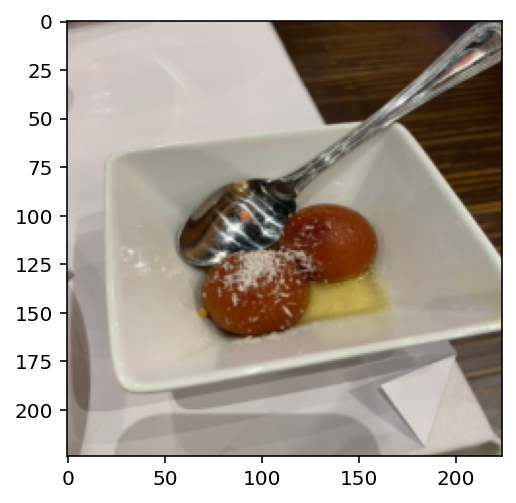

In [ ]:
## To check on a custom Image

img = Image.open('C:/Users/ALEJANDRO/Documents/7. DUKE/1. AIPI 590 - Computer Vision/assignment/First_group_project/CV_Places365/data/test_data/aquarium/Places365_val_00001341.jpg')
# Convert 2D image to 1D vector
images = test_transforms(img)

plt.imshow(denormalise(images))
# Calculate the class probabilities (softmax) for img
with torch.no_grad():
  images = images.to(device)
  output = model(images.unsqueeze(0))

ps = F.softmax(output, dim =1 )

classes[int(torch.argmax(ps).item())]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


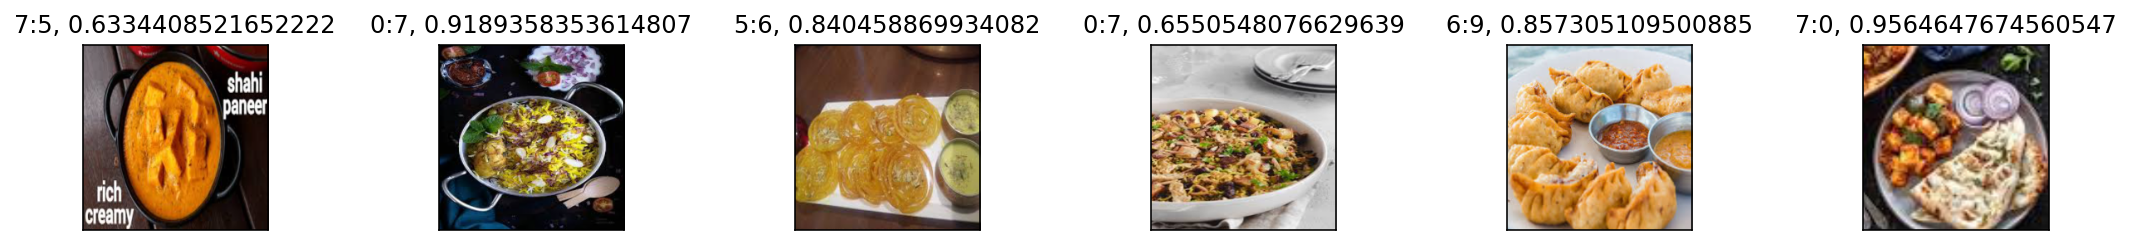

In [ ]:
# Check which images, the model predicted incorrectly with correct and predicted label and the probability

classes
dataiter = iter(test_loader)
images, labels = next(dataiter)
with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  output = model(images)

ps = F.softmax(output, dim =1 )

#images = images.cpu().numpy()


fig = plt.figure(figsize=(25,16))
i = 1
for idx in np.arange(64):
  pred = torch.argmax(ps[idx]).item()
  prob = ps[idx][pred]
  if labels[idx].item() != pred:
    ax = fig.add_subplot(8, 8, i, xticks=[], yticks=[])
    ax.imshow(denormalise(images[idx]), cmap='gray')
    ax.set_title((str(labels[idx].item())+':'+str(pred))+', '+str(prob.item()))
    i+=1

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for images, labels in test_loader:
        with torch.no_grad():
                images = images.to(device)
                output = model(images.unsqueeze(0))

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')